In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import Tracking_Py
import random
import pandas as pd

In [2]:
def print_h5_overview(file_path):
    with h5py.File(file_path, "r") as h5file:
        def visitor_func(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Data type: {obj.dtype}")
                print(f"  Sample data: {obj[()][:5]}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")
                
        h5file.visititems(visitor_func)

In [3]:
def load_data(piv_file):
    
    # with h5py.File(common_filepath+"U_avg.h5", "r") as file:    
    #     U_avg = file["matrix"][:]
    # with h5py.File(common_filepath+"V_avg.h5", "r") as file:    
    #     V_avg = file["matrix"][:]
    # with h5py.File(common_filepath+"M_avg.h5", "r") as file:    
    #     M = file["matrix"][:]
    
    with h5py.File(piv_file, "r") as file:  
        # xgrid and ygrid data the same from original PIV results. 
        U_ori = file["U"][:]
        V_ori = file["V"][:]
        xgrid = file["xgrid"][:]
        ygrid = file["ygrid"][:]
    return U_ori, V_ori, xgrid, ygrid 

In [4]:
U_RA_1, V_RA_1, xgrid_RA_1, ygrid_RA_1 = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_RA/memGFP_RA_1_PIV(IS=32_step=16).h5")
U_RA_2, V_RA_2, xgrid_RA_2, ygrid_RA_2 = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_RA/memGFP_RA_2_PIV(IS=32_step=16).h5")
U_RA_3, V_RA_3, xgrid_RA_3, ygrid_RA_3 = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_RA/memGFP_RA_3_PIV(IS=32_step=16).h5")
U_RA_4, V_RA_4, xgrid_RA_4, ygrid_RA_4 = load_data("F:/PhD_Franziska/Headon/memGFP/memGFP_RA/memGFP_RA_4_PIV(IS=32_step=16).h5")

# Pseudo Tracks on the whole image with random start points. 

Has the advantage that the tracks are not in one limited region of aggregates/vector fields. Allow more complete tracking and therefore less error with tracks (especially long tracks)

In [5]:
# Function to check if all values in an array are identical
def has_identical_values(arr):
    return np.all(arr == arr[0])

def whole_image_pseudo_trajectories(U, V, start_number, t0, t1, PIV_step, pxl_conversion, img_name):
    # Generate pseudo_trajectories for the whole image based on PIV results. 
    
    # Random starting points and the time. 
    start_x_array = [[random.randint(20,900)] for i in range(start_number)]
    start_y_array = [[random.randint(20,900)] for i in range(start_number)]

    t_array = [[t0, t1]]*len(start_x_array)
    
    # x and y coordinates of pseudo trajectories. 
    whole_img_x, whole_img_y = Tracking_Py.pseudo_tracking_piv_grid_v2(U, V, t_array,
                                                                  start_x_array,
                                                                  start_y_array, PIV_step)
    
    # Find out the points where there ist no movement -- either in x or y there should be movement (especially for the case of condensate!)
    arrays_to_filter = []
    for i, (x_array, y_array) in enumerate(zip(whole_img_x, whole_img_y)):
        # Check if there no displacement in both x and y directions. 
        if len(np.unique(x_array)) == 1 and len(np.unique(y_array)) == 1:
            arrays_to_filter.append(i)  # Store the index of matching arrays

    # Plotting. 
    plt.figure(figsize=(4,4), dpi=300)
    for i in range(len(start_x_array)): 
        if i not in arrays_to_filter: # Not plotting the points without movements.
            plt.scatter(start_x_array[i], start_y_array[i], color = "orange", s=4)
            plt.plot(whole_img_x[i], whole_img_y[i], color = "royalblue", alpha=0.5)
    plt.gca().invert_yaxis()
    plt.yticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
    plt.ylabel("distance (μm)")
    plt.xticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
    plt.xlabel("distance (μm)")
    plt.savefig(img_name + ".svg", format="svg")
    plt.show()

    return whole_img_x, whole_img_y  # (start_number, time_points_number) dimensional numpy array. 

In [6]:
# x_coords, y_coords = whole_image_pseudo_trajectories(U_RA_4, V_RA_4, 500, 0, 48, 16, 0.69, "memGFP_RA_4_pseudo_tracks")

In [7]:
def pseudo_track_into_excel(x_coords, y_coords, img_name):
    # Turn the generated pseudo tracks data into excle data file (with the same format as manually generated track tables).
    # xx_coords, y_coords: the list contains numpy arrays recordings pseudo tracks coordinates. 
    # img_name: String. The name of data set applied for generating pseudo tracks.. 

    # Length of each array for x_coords and y_coords. 
    number_frame = np.shape(x_coords[0])[0]
    
    # Define the image name
    image_name = img_name
    
    # Prepare the data for the DataFrame
    data = {
        "Image_ID": [],
        "Track": [],
        "Frame": [],
        "X(pxl)": [],
        "Y(pxl)": []
    }
    
    # Populate the data dictionary
    for track_idx, (x_array, y_array) in enumerate(zip(x_coords, y_coords), start=1):
        for frame_idx, (x_val, y_val) in enumerate(zip(x_array, y_array), start=1):
            data["Image_ID"].append(image_name)
            data["Track"].append(track_idx)
            data["Frame"].append(frame_idx)
            data["X(pxl)"].append(x_val)
            data["Y(pxl)"].append(y_val)
    
    # Create a DataFrame and export it to Excel
    df = pd.DataFrame(data)
    df.to_excel(img_name + "_pseudo_tracks_table.xlsx", index=False)

In [8]:
# pseudo_track_into_excel(x_coords, y_coords, "memGFP_10_um_RA_4_(29.08.24)")

# Pseudo Tracks Analysis 
Measurement conversion: time between frames: 10 min, 1 pixel length/width = 0.69 μm. 
1. Speed (μm/min): The track length devided by the time
2. Euclidean distance: The Euclidean distance between start and end points for each track.
3. Persistence: Euclidean distance divided by the total distance travelled by the cell.

In [9]:
# The Euclidean distance between strat and end points for each pseudo trajectory.
# Without considering the measure conversion -- in pixel. 

def calculate_start_end_distance_pixel(x, y):
    # Calculate the Euclidean distance between the start and end points
    start_x, end_x = x[0], x[-1]
    start_y, end_y = y[0], y[-1]
    distance = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    return distance

In [10]:
# Calculate the track length for each pseudo trajectories. 
# Without considering the measure conversion -- in pixel.

def calculate_trajectory_length_pixel(x, y):
    # Calculate the differences between consecutive points
    dx = np.diff(x)
    dy = np.diff(y)
    # Calculate the Euclidean distance for each segment and sum them
    length = np.sum(np.sqrt(dx**2 + dy**2))
    return length

### Speed

Gather the speed data from all available data sets. Do violin plot with all speed data. Highlight the single data set with dots. 

In [11]:
# Speed calculation. 

def speed_calculation(x_coords, y_coords, time_conversion, pixel_conversion): 

    # Calculate the total time for trajectory. 
    frame_number = np.shape(x_coords)[1] - 1
    total_time = frame_number * time_conversion

    # Compute the length for each trajectory
    trajectory_lengths = np.array([calculate_trajectory_length_pixel(x, y) for x, y in zip(x_coords, y_coords)])
    # Take account into the measure conversion. Speed = total track length / total time
    trajectory_speed = trajectory_lengths * pixel_conversion / total_time

    return trajectory_speed

# speed = speed_calculation(x_coords, y_coords, 10, 0.69)

In [12]:
# Create an empty .h5 file for storing trajectory speed data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("trajectory_speed.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("trajectory_speed.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_4", data=speed)

# Overview of .h5 file containing speed information. 
print_h5_overview("trajectory_speed.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.08016442 0.11608879 0.11604663 0.07649827 0.06256234]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.05569919 0.07981877 0.07678492 0.0760845  0.09413625]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.09238787 0.12488392 0.07820858 0.12061416 0.13606534]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.06339805 0.07001948 0.06536785 0.06350963 0.0689759 ]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.1195162  0.13053807 0.13863882 0.1138358  0.12796275]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.06516749 0.16732329 0.11364459 0.11863304 0.11874935]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [0.13898752 0.12019579 0.13157263 0.11545238 0.12258627]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.12975483 0.13235013 0.10437288 0.11583552 0.11262326]
Datas

In [13]:
with h5py.File("trajectory_speed.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    speed_DAPT_1 = file["DAPT_1"][:]
    speed_DAPT_2 = file["DAPT_2"][:]
    speed_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    speed_DAPT = np.concatenate([speed_DAPT_1, speed_DAPT_2, speed_DAPT_3])

    # Data set under RA condition. 
    speed_RA_1 = file["RA_1"][:]
    speed_RA_2 = file["RA_2"][:]
    speed_RA_3 = file["RA_3"][:]
    speed_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    speed_RA = np.concatenate([speed_RA_1, speed_RA_2, speed_RA_3, speed_RA_4])

    # Data set under control condition. 
    speed_control_1 = file["control_1"][:]
    speed_control_2 = file["control_2"][:]
    speed_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    speed_control = np.concatenate([speed_control_1, speed_control_2, speed_control_3_condensate_cut[speed_control_3_condensate_cut != 0]])

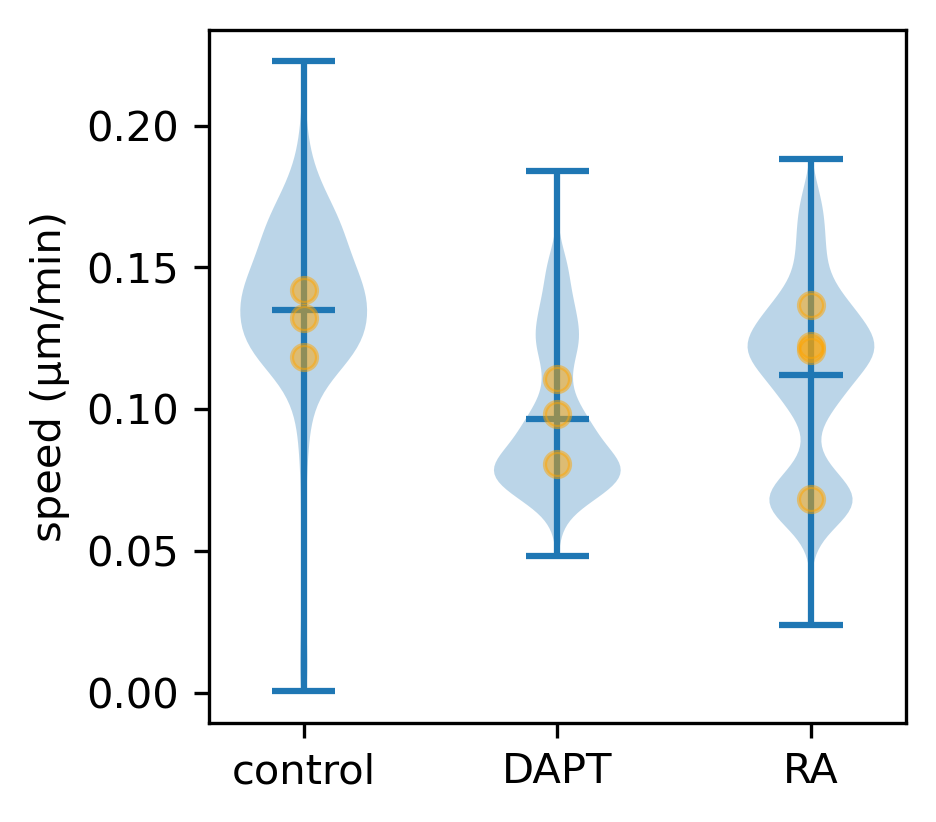

In [14]:
plt.figure(figsize=(3,3),dpi=300)
plt.violinplot([speed_control, speed_DAPT, speed_RA], showmeans=True) #, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(speed_control_1), np.mean(speed_control_2), 
                    np.mean(speed_control_3_condensate_cut)], color="orange", alpha=0.5, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(speed_DAPT_1), np.mean(speed_DAPT_2), 
                    np.mean(speed_DAPT_3)], color="orange", alpha=0.5, zorder=2)
# For RA data set. 
plt.scatter([3]*4, [np.mean(speed_RA_1), np.mean(speed_RA_2), 
                    np.mean(speed_RA_3), np.mean(speed_RA_4)], color="orange", alpha=0.5, zorder=2)

# Customize the plot. 
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 0.05, 0.1, 0.15, 0.2])
plt.ylabel("speed (μm/min)")
plt.savefig("pseudo_trajectory_speed.svg", format="svg")

### Euclidean Distance

Gather the Euclidean distance data from all available data sets. Do violin plot with all Euclidean data. Highlight the single data set with dots. 

In [15]:
def euclidean_distance_calculation(x_coords, y_coords, pixel_conversion):
    # Compute the start-to-end distance for each trajectory
    start_end_distances = np.array([calculate_start_end_distance_pixel(x, y) for x, y in zip(x_coords, y_coords)])
    return pixel_conversion * start_end_distances # Take the measure conversion into account. 

In [16]:
# euclidean_distance = euclidean_distance_calculation(x_coords, y_coords, 0.69)

In [17]:
# Create an empty .h5 file for storing Euclidean distance data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("euclidean_distance.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("euclidean_distance.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_4", data=euclidean_distance)

# Overview of .h5 file containing speed information. 
print_h5_overview("euclidean_distance.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [19.14637999 34.74077419 32.88847691 15.54321348 10.43469673]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [ 2.62884347 10.72300645 14.54461386  6.99732608  6.63937366]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [27.81464519 41.03147123 22.60624994 48.24122676 44.4518715 ]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [ 6.27509965 10.29936419  8.03458161  8.21244588  7.112068  ]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [ 9.7987521  13.17668762 15.24610333  4.65849168  9.59453326]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [14.92429631 74.07585916 38.06019406 45.9921715  35.66047836]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [30.66327339 29.73060136 46.3124811  30.41674626 37.73789004]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [51.1703791  26.42893161 13

In [18]:
with h5py.File("euclidean_distance.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    dist_DAPT_1 = file["DAPT_1"][:]
    dist_DAPT_2 = file["DAPT_2"][:]
    dist_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    dist_DAPT = np.concatenate([dist_DAPT_1, dist_DAPT_2, dist_DAPT_3])

    # Data set under RA condition. 
    dist_RA_1 = file["RA_1"][:]
    dist_RA_2 = file["RA_2"][:]
    dist_RA_3 = file["RA_3"][:]
    dist_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    dist_RA = np.concatenate([dist_RA_1, dist_RA_2, dist_RA_3, dist_RA_4])

    # Data set under control condition. 
    dist_control_1 = file["control_1"][:]
    dist_control_2 = file["control_2"][:]
    dist_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    dist_control = np.concatenate([dist_control_1, dist_control_2, dist_control_3_condensate_cut[dist_control_3_condensate_cut != 0]])

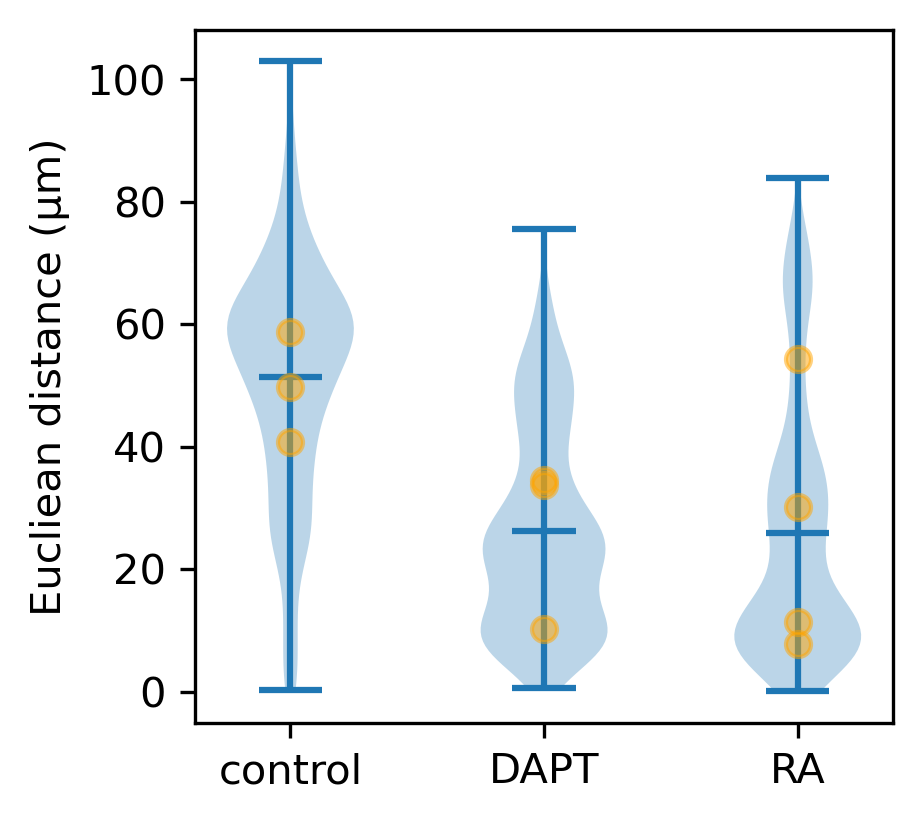

In [19]:
plt.figure(figsize=(3,3), dpi=300)
plt.violinplot([dist_control, dist_DAPT, dist_RA], showmeans=True)#, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(dist_control_1), np.mean(dist_control_2), 
                    np.mean(dist_control_3_condensate_cut)], color="orange", alpha=0.5, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(dist_DAPT_1), np.mean(dist_DAPT_2), 
                    np.mean(dist_DAPT_3)], color="orange", alpha=0.5, zorder=2)
# For RA data set. 
plt.scatter([3]*4, [np.mean(dist_RA_1), np.mean(dist_RA_2), 
                    np.mean(dist_RA_3), np.mean(dist_RA_4)], color="orange", alpha=0.5, zorder=2)

# Customize the plot
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 20, 40, 60, 80, 100])
plt.ylabel("Eucliean distance (μm)")
plt.savefig("pseudo_trajectory_Euclidean_distance.svg", format="svg")

### Persistence

Gather the persistence data from all available data sets. Do violin plot with all persistence data. Highlight the single data set with dots. 

In [20]:
def persistence(x_coords, y_coords): 

    # Euclidean Distance for each trajectory.
    start_end_distances = np.array([calculate_start_end_distance_pixel(x, y) for x, y in zip(x_coords, y_coords)])

    # Compute the length for each trajectory
    trajectory_lengths = np.array([calculate_trajectory_length_pixel(x, y) for x, y in zip(x_coords, y_coords)])

    # Persistence = Euclidean distance / trajectory length.  
    persistence = start_end_distances / trajectory_lengths
    # Filter out the NaN produced through deviding by 0. 
    persistence_filtered = persistence[~np.isnan(persistence)]

    return persistence_filtered 

# persistence = persistence(x_coords, y_coords)

In [21]:
# Create an empty .h5 file for storing persistence data cross different data set. 

# # Create an empty .h5 file
# with h5py.File("persistence.h5", "w") as h5file:
#     pass  # No data added yet

# Open the empty .h5 file in append mode to add datasets
# with h5py.File("persistence.h5", "a") as h5file:
#     # Add a dataset named by img_name. 
#     # del h5file["DAPT_3"] # Delete first if want to overwrite.
#     h5file.create_dataset("RA_4", data=persistence)

# Overview of .h5 file containing speed information. 
print_h5_overview("persistence.h5")

Dataset: DAPT_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.49758102 0.62345913 0.59043215 0.42329967 0.34747664]
Dataset: DAPT_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.09832741 0.27987898 0.39462541 0.19159965 0.14693626]
Dataset: DAPT_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.62721632 0.6844935  0.60218912 0.83325669 0.68061464]
Dataset: RA_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.20620704 0.30644343 0.25606948 0.26939634 0.21481137]
Dataset: RA_2
  Shape: (500,)
  Data type: float64
  Sample data: [0.17080586 0.21029445 0.22910405 0.08525605 0.15620648]
Dataset: RA_3
  Shape: (500,)
  Data type: float64
  Sample data: [0.4771134  0.92231454 0.69771969 0.80767567 0.62562584]
Dataset: RA_4
  Shape: (500,)
  Data type: float64
  Sample data: [0.4596227  0.51531548 0.73331617 0.5488689  0.64134919]
Dataset: control_1
  Shape: (500,)
  Data type: float64
  Sample data: [0.82158758 0.4160198  0.27518684 0.64580925 0.40389959]
Datas

In [22]:
with h5py.File("persistence.h5", "r") as file:  # Assume already know the .h5 data overview. Otherwise use the above overview function.
    # Data set under DAPT condition.
    persist_DAPT_1 = file["DAPT_1"][:]
    persist_DAPT_2 = file["DAPT_2"][:]
    persist_DAPT_3 = file["DAPT_3"][:]
    # Create the array containing all speed data. 
    persist_DAPT = np.concatenate([persist_DAPT_1, persist_DAPT_2, persist_DAPT_3])

    # Data set under RA condition. 
    persist_RA_1 = file["RA_1"][:]
    persist_RA_2 = file["RA_2"][:]
    persist_RA_3 = file["RA_3"][:]
    persist_RA_4 = file["RA_4"][:]
    # Create the array containing all speed data. 
    persist_RA = np.concatenate([persist_RA_1, persist_RA_2, persist_RA_3, persist_RA_4])

    # Data set under control condition. 
    persist_control_1 = file["control_1"][:]
    persist_control_2 = file["control_2"][:]
    persist_control_3_condensate_cut = file["control_3(condensate_cut)"][:] # Have to filter out 0 because of condensates. 
    # Create the array containing all speed data. 
    persist_control = np.concatenate([persist_control_1, persist_control_2, persist_control_3_condensate_cut[persist_control_3_condensate_cut != 0]])

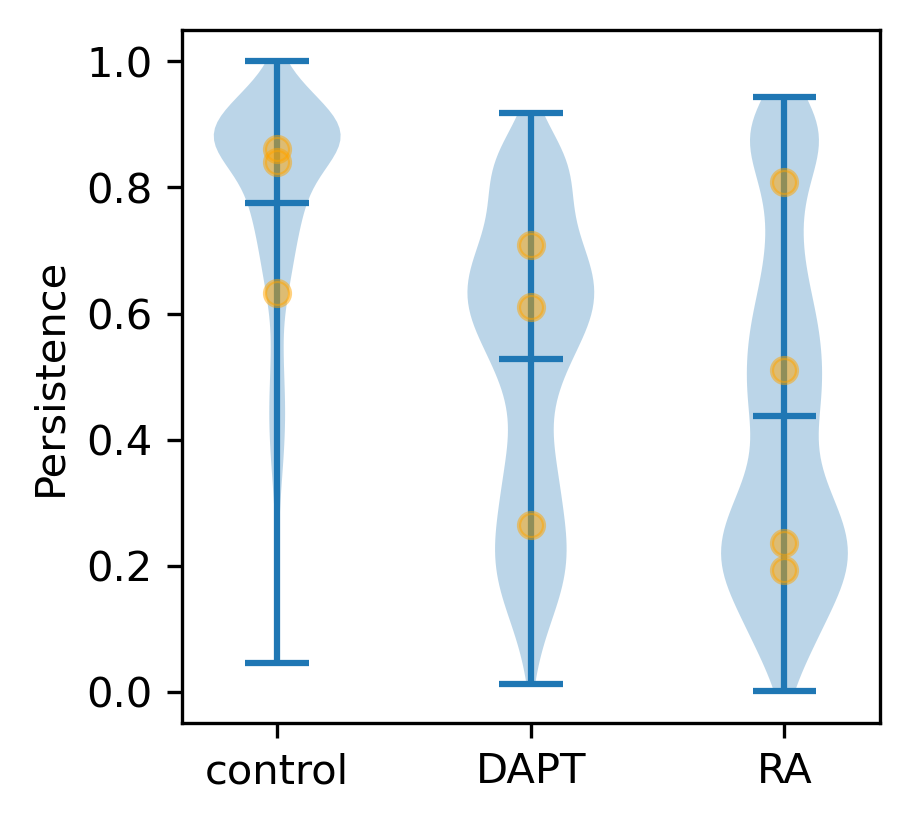

In [24]:
plt.figure(figsize=(3,3), dpi=300)
plt.violinplot([persist_control, persist_DAPT, persist_RA], showmeans=True)#, showmedians=True)

# Plot the mean of each simgle sample on the violin bars. 
# For control data set. 
plt.scatter([1]*3, [np.mean(persist_control_1), np.mean(persist_control_2), 
                    np.mean(persist_control_3_condensate_cut)], color="orange", alpha=0.5, zorder=2)
# For DAPT data set.
plt.scatter([2]*3, [np.mean(persist_DAPT_1), np.mean(persist_DAPT_2), 
                    np.mean(persist_DAPT_3)], color="orange", alpha=0.5, zorder=2)
# For RA data set. 
plt.scatter([3]*4, [np.mean(persist_RA_1), np.mean(persist_RA_2), 
                    np.mean(persist_RA_3), np.mean(persist_RA_4)], color="orange", alpha=0.5, zorder=2)

# Customize the plot
plt.xticks([1, 2, 3], ["control", "DAPT", "RA"])  # Label each part
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.ylabel("Persistence")
plt.savefig("pseudo_trajectory_persistence.svg", format="svg")